# Assignment 1 - Bonus

> Tristan PERROT

## Utils

### Librairies


In [59]:
import tarfile
import urllib.request
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

DATASET_PATH = '../Dataset/'

### Functions


In [60]:
def load_batch(filename):
    """ Copied from the dataset website """
    import pickle
    with open(DATASET_PATH + filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def montage(W):
    """ Display the image for each label in W """
    fig, ax = plt.subplots(2, 5)
    fig.suptitle("Montage of the dataset")
    for i in range(2):
        for j in range(5):
            im = W[i * 5 + j, :].reshape(32, 32, 3, order='F')
            sim = (im - np.min(im[:])) / (np.max(im[:]) - np.min(im[:]))
            sim = sim.transpose(1, 0, 2)
            ax[i][j].imshow(sim, interpolation='nearest')
            ax[i][j].axis('off')
    return fig


def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def compute_grads_num(X, Y, P, W, b, lmbda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))

    c = compute_cost(X, Y, W, b, lmbda)

    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] += h
        c2 = compute_cost(X, Y, W, b_try, lmbda)
        grad_b[i] = (c2 - c) / h

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i, j] += h
            c2 = compute_cost(X, Y, W_try, b, lmbda)
            grad_W[i, j] = (c2 - c) / h

    return [grad_W, grad_b]


def compute_grads_num_slow(X, Y, P, W, b, lmbda, h):
    """ Converted from matlab code """
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))

    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] -= h
        c1 = compute_cost(X, Y, W, b_try, lmbda)

        b_try = np.array(b)
        b_try[i] += h
        c2 = compute_cost(X, Y, W, b_try, lmbda)

        grad_b[i] = (c2 - c1) / (2 * h)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i, j] -= h
            c1 = compute_cost(X, Y, W_try, b, lmbda)

            W_try = np.array(W)
            W_try[i, j] += h
            c2 = compute_cost(X, Y, W_try, b, lmbda)

            grad_W[i, j] = (c2 - c1) / (2 * h)

    return [grad_W, grad_b]

## Exercices

### Exercice 1 - Re use


#### 1.1: Read in and store the training, validation and test data.


In [61]:
def load_data(filename):
    """ Read the data from the file """
    data = load_batch(filename)
    X = data[b'data'].T / 255
    y = np.array(data[b'labels'])
    Y = np.zeros((10, X.shape[1]))
    for i in range(y.shape[0]):
        Y[y[i], i] = 1
    return X, Y, y


def split_data(X, Y, y, split_ratio=0.8):
    """ Split the data into a training set and a validation set """
    n = X.shape[1]
    n_train = int(n * split_ratio)
    X_train = X[:, :n_train]
    Y_train = Y[:, :n_train]
    y_train = y[:n_train]
    X_val = X[:, n_train:]
    Y_val = Y[:, n_train:]
    y_val = y[n_train:]
    return X_train, Y_train, y_train, X_val, Y_val, y_val


def save_data(filename, X_train, Y_train, y_train, X_val, Y_val, y_val, X_test, Y_test, y_test):
    """ Save the data to a file """
    np.savez(DATASET_PATH + filename, X_train=X_train, Y_train=Y_train, y_train=y_train,
             X_val=X_val, Y_val=Y_val, y_val=y_val, X_test=X_test, Y_test=Y_test, y_test=y_test)


def read_data(filename):
    """ Read the data from a file """
    data = np.load(DATASET_PATH + filename + '.npz')
    X_train = data['X_train']
    Y_train = data['Y_train']
    y_train = data['y_train']
    X_val = data['X_val']
    Y_val = data['Y_val']
    y_val = data['y_val']
    X_test = data['X_test']
    Y_test = data['Y_test']
    y_test = data['y_test']
    return X_train, Y_train, y_train, X_val, Y_val, y_val, X_test, Y_test, y_test

In [62]:
# Display one image per label
def display_images(X, y):
    fig, ax = plt.subplots(2, 5)
    fig.suptitle("Labels and images associated")
    for i in range(2):
        for j in range(5):
            im = X[:, y == 5 * i + j][:, 0] \
                .reshape(3, 32, 32).transpose(1, 2, 0)
            ax[i][j].imshow(im)
            ax[i][j].set_title("y=" + str(5 * i + j))
            ax[i][j].axis('off')
    plt.tight_layout()
    plt.savefig('Result_Pics/labels_images.png')
    return fig

#### 1.2: Compute the mean and standard deviation vector for the training data and then normalize the training, validation and test data w.r.t. these mean and standard deviation vectors.


In [63]:
def mean_std_normalization(X_train, X_val, X_test):
    mean_X = np.mean(X_train, axis=1).reshape(-1, 1)
    std_X = np.std(X_train, axis=1).reshape(-1, 1)
    X_train = (X_train - mean_X) / std_X
    X_val = (X_val - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X
    return X_train, X_val, X_test

#### 1.3: Initialize the parameters


In [64]:
def initialize_parameters(K, d):
    """ Initialize the parameters """
    W = np.random.normal(0, 0.01, (K, d))
    b = np.random.normal(0, 0.01, (K, 1))
    return W, b

#### 1.4: Evaluate network function


In [65]:
def evaluate_classifier(X, W, b):
    """ Evaluate the network function """
    return softmax(W @ X + b)

#### 1.5: Compute the cost function


In [66]:
def compute_cost(X, Y, W, b, lmbda):
    """ Compute the cost function """
    n = X.shape[1]
    P = evaluate_classifier(X, W, b)
    cross_entropy = -np.log(np.sum(Y * P, axis=0))
    return np.sum(cross_entropy) / n + lmbda * np.sum(W ** 2)


def compute_loss(X, Y, W, b):
    """ Compute the loss function """
    n = X.shape[1]
    P = evaluate_classifier(X, W, b)
    cross_entropy = -np.log(np.sum(Y * P, axis=0))
    return np.sum(cross_entropy) / n

#### 1.6: Compute the accuracy


In [67]:
def compute_accuracy(X, y, W, b):
    """ Compute the accuracy of the classifier """
    P = evaluate_classifier(X, W, b)
    return np.sum(np.argmax(P, axis=0) == y) / X.shape[1]

#### 1.7: Compute the gradients of the cost function


In [68]:
def compute_gradients(X, Y, P, W, lmbda):
    """ Compute the gradients of the cost function """
    n = X.shape[1]
    G = -(Y - P)
    grad_W = G @ X.T / n + 2 * lmbda * W
    grad_b = np.sum(G, axis=1).reshape(-1, 1) / n
    return grad_W, grad_b


def compute_relative_error(grad_analytical, grad_numerical, eps=1e-9):
    """ Compute the relative error between the analytical and numerical gradients """
    return np.max(
        np.abs(grad_analytical - grad_numerical) / np.maximum(eps, np.abs(grad_analytical) + np.abs(grad_numerical)))

#### 1.8: Implement the mini-batch gradient descent algorithm


In [69]:
def mini_batch_gd(X_train, Y_train, y_train, X_val, Y_val, y_val, W, b, lmbda=0., n_batch=100, n_epochs=40, eta=.001, verbose=True):
    """ Implement the mini-batch gradient descent algorithm """
    n = X_train.shape[1]
    costs_train, costs_val = [], []
    losses_train, losses_val = [], []
    accuracies_train, accuracies_val = [], []
    for epoch in range(n_epochs):
        # Shuffle the data
        indices = np.random.permutation(n)
        X_train_shuffled = X_train[:, indices]
        Y_train_shuffled = Y_train[:, indices]
        for j in range(0, n, n_batch):
            j_end = min(j + n_batch, n)
            X_batch = X_train_shuffled[:, j:j_end]
            Y_batch = Y_train_shuffled[:, j:j_end]
            P_batch = evaluate_classifier(X_batch, W, b)
            grad_W, grad_b = compute_gradients(
                X_batch, Y_batch, P_batch, W, lmbda)
            W -= eta * grad_W
            b -= eta * grad_b
        costs_train.append(compute_cost(X_train, Y_train, W, b, lmbda))
        costs_val.append(compute_cost(X_val, Y_val, W, b, lmbda))
        losses_train.append(compute_loss(X_train, Y_train, W, b))
        losses_val.append(compute_loss(X_val, Y_val, W, b))
        accuracies_train.append(compute_accuracy(X_train, y_train, W, b))
        accuracies_val.append(compute_accuracy(X_val, y_val, W, b))
        if verbose:
            print(f"Epoch {epoch + 1}/{n_epochs}: Cost train: {costs_train[-1]:.4f}, Cost val: {
                costs_val[-1]:.4f}, Accuracy train: {accuracies_train[-1]:.4f}, Accuracy val: {accuracies_val[-1]:.4f}")
    return W, b, costs_train, costs_val, losses_train, losses_val, accuracies_train, accuracies_val

#### 1.9: Train the network


In [70]:
def train_and_plot(X_train, Y_train, y_train, X_val, Y_val, y_val, X_test, y_test, sup_title="", save=True, verbose=True, lmbda=0.1, n_batch=100, n_epochs=40, eta=.001):
    W, b = initialize_parameters(Y_train.shape[0], X_train.shape[0])
    W, b, costs_train, costs_val, losses_train, losses_val, accuracies_train, accuracies_val = mini_batch_gd(
        X_train, Y_train, y_train, X_val, Y_val, y_val, W, b, lmbda=lmbda, n_batch=n_batch, n_epochs=n_epochs, eta=eta, verbose=verbose)

    # 1.11: Compute the accuracy on the test set

    accuracy_test = compute_accuracy(X_test, y_test, W, b)
    print("Hyperparameters: lambda=", lmbda, ", n_batch=", n_batch,
          ", n_epochs=", n_epochs, ", eta=", eta)
    print("Accuracy test: ", accuracy_test)

    # 1.10: Plot the cost function and accuracy

    os.makedirs('Result_Pics', exist_ok=True)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Cost, loss and accuracy, final accuracy test: {
        accuracy_test * 100:.2f}%")
    ax[0].plot(costs_train, label='Training set')
    ax[0].plot(costs_val, label='Validation set')
    ax[0].set_title("Cost function")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Cost")
    ax[0].legend()
    ax[1].plot(losses_train, label='Training set')
    ax[1].plot(losses_val, label='Validation set')
    ax[1].set_title("Loss function")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    ax[2].plot(accuracies_train, label='Training set')
    ax[2].plot(accuracies_val, label='Validation set')
    ax[2].set_title("Accuracy")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Accuracy")
    ax[2].legend()
    fig.tight_layout()
    if save:
        fig.savefig(
            f'Result_Pics/cost_loss_accuracy{sup_title}.png')

    # 1.12: Visualize the weights

    fig = montage(W)
    fig.tight_layout()
    if save:
        fig.savefig(
            f'Result_Pics/weights{sup_title}.png')

    return accuracy_test

## Exercice 2.1 - Improve performance of the network

### A. Increase the size of the training set


In [71]:
def load_all_data():
    """ Load all the data """
    X, Y, y = load_data('data_batch_1')
    for i in range(2, 6):
        X_i, Y_i, y_i = load_data(f'data_batch_{i}')
        X = np.concatenate((X, X_i), axis=1)
        Y = np.concatenate((Y, Y_i), axis=1)
        y = np.concatenate((y, y_i))
    X_test, Y_test, y_test = load_data('test_batch')
    return X, Y, y, X_test, Y_test, y_test

In [79]:
X, Y, y, X_test, Y_test, y_test = load_all_data()
X_train, Y_train, y_train, X_val, Y_val, y_val = split_data(
    X, Y, y, (X.shape[1] - 1000)/X.shape[1])
print("Loaded all the data")
print("X._train.shape:", X_train.shape, "; Y_train.shape:",
      Y_train.shape, "; y_train.shape:", y_train.shape)
print("X_val.shape:", X_val.shape, "; Y_val.shape:",
      Y_val.shape, "; y_val.shape:", y_val.shape)
print("X_test.shape:", X_test.shape, "; Y_test.shape:",
      Y_test.shape, "; y_test.shape:", y_test.shape)

Loaded all the data
X._train.shape: (3072, 49000) ; Y_train.shape: (10, 49000) ; y_train.shape: (49000,)
X_val.shape: (3072, 1000) ; Y_val.shape: (10, 1000) ; y_val.shape: (1000,)
X_test.shape: (3072, 10000) ; Y_test.shape: (10, 10000) ; y_test.shape: (10000,)


In [80]:
X_train, X_val, X_test = mean_std_normalization(X_train, X_val, X_test)

### C. Grid search


Hyperparameters: lambda= 0.1 , n_batch= 100 , n_epochs= 40 , eta= 0.001
Accuracy test:  0.4097


0.4097

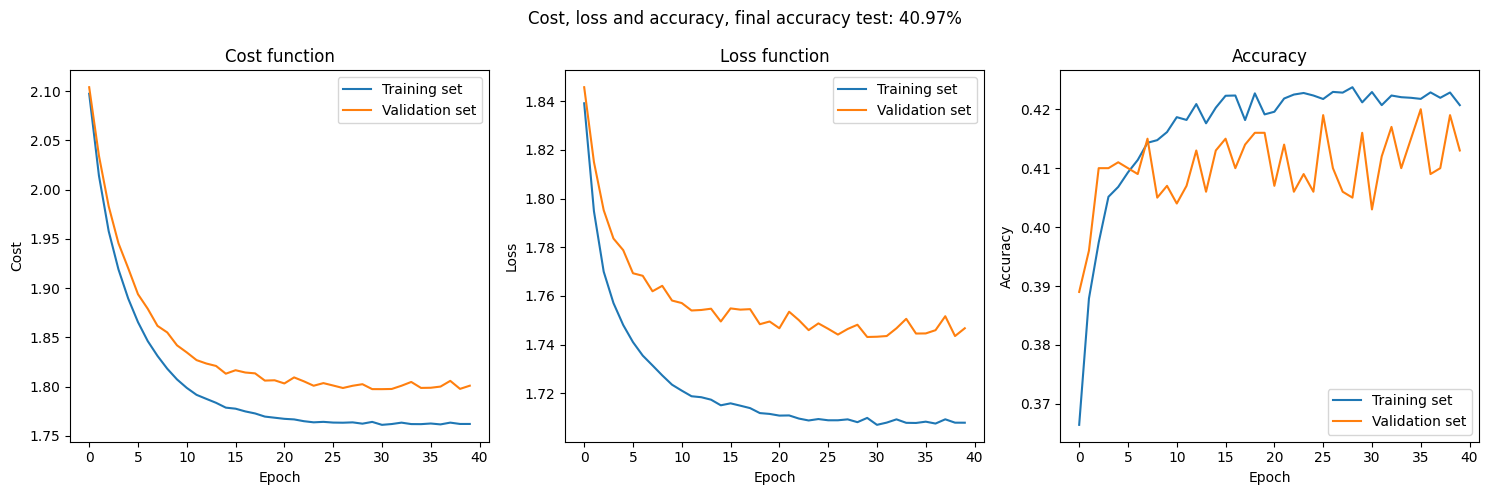

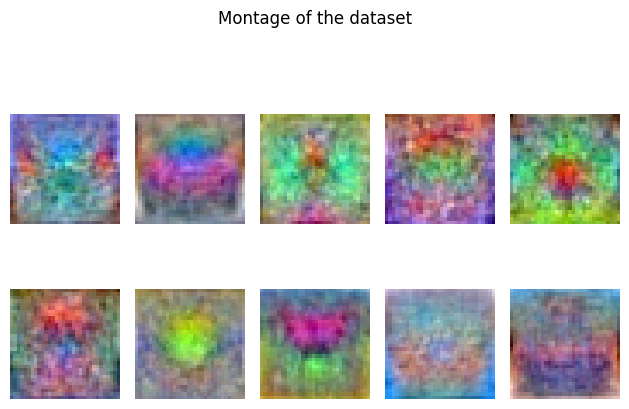

In [82]:
lmbda = 0.1
n_epochs = 40
n_batch = 100
eta = 0.001
train_and_plot(X_train, Y_train, y_train, X_val, Y_val,
               y_val, X_test, y_test, f"_all_data_previous_{lmbda}_{n_epochs}_{n_batch}_{eta}", verbose=False, lmbda=lmbda, n_epochs=n_epochs, n_batch=n_batch, eta=eta)

In [86]:
lmbda_list = [0.1, 0.2, 0.4]
n_epochs = 40
n_batch_list = [100, 200, 500]
eta_list = [.005, .001, .0005]

best_accuracy = 0
best_hyperparameters = None
for lmbda in lmbda_list:
    for n_batch in n_batch_list:
        for eta in eta_list:
            W, b = initialize_parameters(Y_train.shape[0], X_train.shape[0])
            W, b, costs_train, costs_val, losses_train, losses_val, accuracies_train, accuracies_val = mini_batch_gd(
                X_train, Y_train, y_train, X_val, Y_val, y_val, W, b, lmbda=lmbda, n_batch=n_batch, n_epochs=n_epochs, eta=eta, verbose=False)
            accuracy = compute_accuracy(X_test, y_test, W, b)
            print("Hyperparameters: lambda=", lmbda, ", n_batch=", n_batch,
                  ", n_epochs=", n_epochs, ", eta=", eta)
            print("Accuracy test: ", accuracy)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = (lmbda, n_epochs, n_batch, eta)

Hyperparameters: lambda= 0.1 , n_batch= 100 , n_epochs= 40 , eta= 0.005
Accuracy test:  0.4037
Hyperparameters: lambda= 0.1 , n_batch= 100 , n_epochs= 40 , eta= 0.001
Accuracy test:  0.4076
Hyperparameters: lambda= 0.1 , n_batch= 100 , n_epochs= 40 , eta= 0.0005
Accuracy test:  0.4068
Hyperparameters: lambda= 0.1 , n_batch= 200 , n_epochs= 40 , eta= 0.005
Accuracy test:  0.4085
Hyperparameters: lambda= 0.1 , n_batch= 200 , n_epochs= 40 , eta= 0.001
Accuracy test:  0.4056
Hyperparameters: lambda= 0.1 , n_batch= 200 , n_epochs= 40 , eta= 0.0005
Accuracy test:  0.4078
Hyperparameters: lambda= 0.1 , n_batch= 500 , n_epochs= 40 , eta= 0.005
Accuracy test:  0.4081
Hyperparameters: lambda= 0.1 , n_batch= 500 , n_epochs= 40 , eta= 0.001
Accuracy test:  0.403
Hyperparameters: lambda= 0.1 , n_batch= 500 , n_epochs= 40 , eta= 0.0005
Accuracy test:  0.3965
Hyperparameters: lambda= 0.2 , n_batch= 100 , n_epochs= 40 , eta= 0.005
Accuracy test:  0.3806
Hyperparameters: lambda= 0.2 , n_batch= 100 , n_

Best hyperparameters: (0.1, 40, 200, 0.005)
Best accuracy: 0.4085
Hyperparameters: lambda= 0.1 , n_batch= 200 , n_epochs= 40 , eta= 0.005
Accuracy test:  0.4063


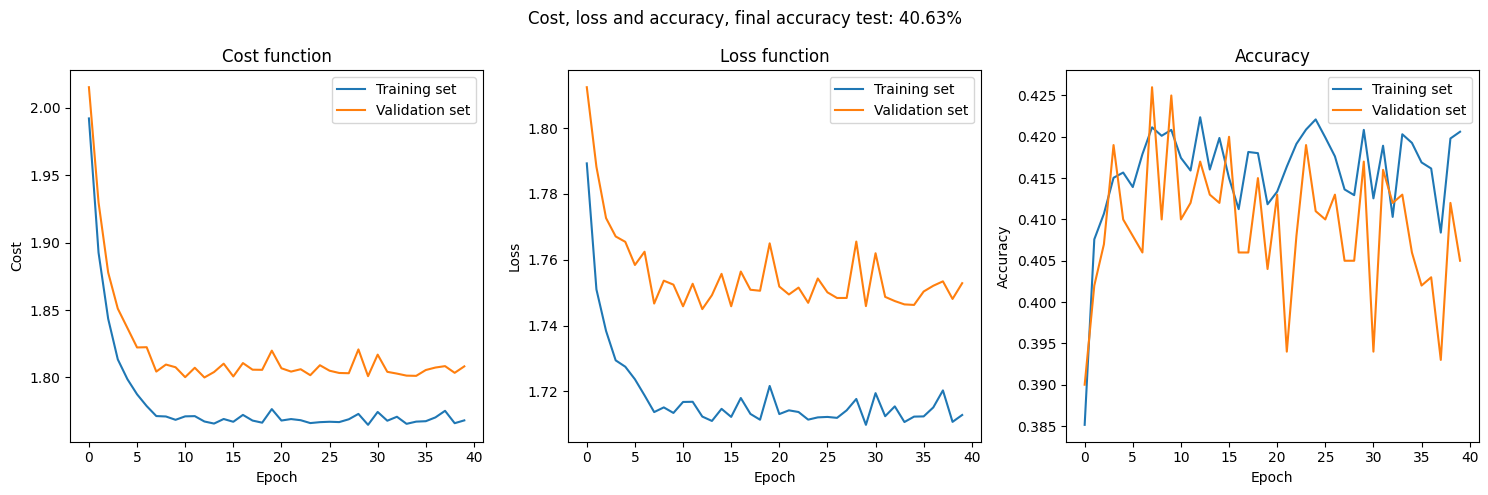

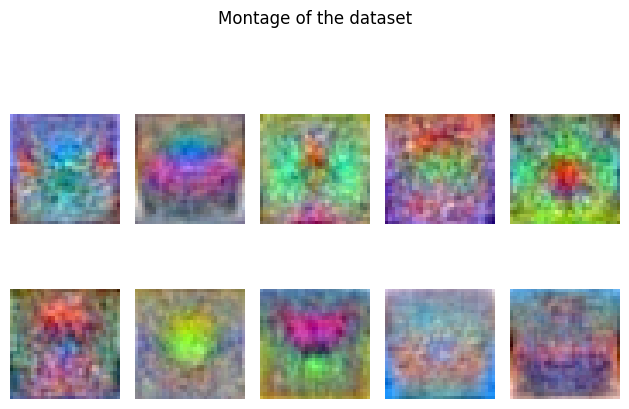

In [87]:
print("Best hyperparameters:", best_hyperparameters)
print("Best accuracy:", best_accuracy)
lmbda, n_epochs, n_batch, eta = best_hyperparameters
accuracy_test = train_and_plot(X_train, Y_train, y_train, X_val, Y_val,
                               y_val, X_test, y_test, f"_all_data_grid_searched_{lmbda}_{n_epochs}_{n_batch}_{eta}", save=True, verbose=False, lmbda=lmbda, n_batch=n_batch, n_epochs=n_epochs, eta=eta)

### D. Step Decay


In [90]:
def mini_batch_gd_step_decay(X_train, Y_train, y_train, X_val, Y_val, y_val, W, b, lmbda=0., n_batch=100, n_epochs=40, eta=.001, verbose=True):
    """ Implement the mini-batch gradient descent algorithm """
    n = X_train.shape[1]
    costs_train, costs_val = [], []
    losses_train, losses_val = [], []
    accuracies_train, accuracies_val = [], []
    for epoch in range(n_epochs):
        # Shuffle the data
        indices = np.random.permutation(n)
        X_train_shuffled = X_train[:, indices]
        Y_train_shuffled = Y_train[:, indices]
        for j in range(0, n, n_batch):
            j_end = min(j + n_batch, n)
            X_batch = X_train_shuffled[:, j:j_end]
            Y_batch = Y_train_shuffled[:, j:j_end]
            P_batch = evaluate_classifier(X_batch, W, b)
            grad_W, grad_b = compute_gradients(
                X_batch, Y_batch, P_batch, W, lmbda)
            W -= eta * grad_W
            b -= eta * grad_b
        costs_train.append(compute_cost(X_train, Y_train, W, b, lmbda))
        costs_val.append(compute_cost(X_val, Y_val, W, b, lmbda))
        losses_train.append(compute_loss(X_train, Y_train, W, b))
        losses_val.append(compute_loss(X_val, Y_val, W, b))
        accuracies_train.append(compute_accuracy(X_train, y_train, W, b))
        accuracies_val.append(compute_accuracy(X_val, y_val, W, b))
        if verbose:
            print(f"Epoch {epoch + 1}/{n_epochs}: Cost train: {costs_train[-1]:.4f}, Cost val: {
                costs_val[-1]:.4f}, Accuracy train: {accuracies_train[-1]:.4f}, Accuracy val: {accuracies_val[-1]:.4f}")
        # If the validation seems to plateau, decaying the learning rate by 10
        if len(costs_val) > 1 and epoch % 10 == 0:
            eta *= 0.1
    return W, b, costs_train, costs_val, losses_train, losses_val, accuracies_train, accuracies_val


def train_and_plot_step_decay(X_train, Y_train, y_train, X_val, Y_val, y_val, X_test, y_test, sup_title="", save=True, verbose=True, lmbda=0.1, n_batch=100, n_epochs=40, eta=.001):
    W, b = initialize_parameters(Y_train.shape[0], X_train.shape[0])
    W, b, costs_train, costs_val, losses_train, losses_val, accuracies_train, accuracies_val = mini_batch_gd_step_decay(
        X_train, Y_train, y_train, X_val, Y_val, y_val, W, b, lmbda=lmbda, n_batch=n_batch, n_epochs=n_epochs, eta=eta, verbose=verbose)

    # 1.11: Compute the accuracy on the test set

    accuracy_test = compute_accuracy(X_test, y_test, W, b)
    print("Hyperparameters: lambda=", lmbda, ", n_batch=", n_batch,
          ", n_epochs=", n_epochs, ", eta=", eta)
    print("Accuracy test: ", accuracy_test)

    # 1.10: Plot the cost function and accuracy

    os.makedirs('Result_Pics', exist_ok=True)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Cost, loss and accuracy, final accuracy test: {
        accuracy_test * 100:.2f}%")
    ax[0].plot(costs_train, label='Training set')
    ax[0].plot(costs_val, label='Validation set')
    ax[0].set_title("Cost function")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Cost")
    ax[0].legend()
    ax[1].plot(losses_train, label='Training set')
    ax[1].plot(losses_val, label='Validation set')
    ax[1].set_title("Loss function")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    ax[2].plot(accuracies_train, label='Training set')
    ax[2].plot(accuracies_val, label='Validation set')
    ax[2].set_title("Accuracy")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Accuracy")
    ax[2].legend()
    fig.tight_layout()
    if save:
        fig.savefig(
            f'Result_Pics/cost_loss_accuracy{sup_title}.png')

    # 1.12: Visualize the weights

    fig = montage(W)
    fig.tight_layout()
    if save:
        fig.savefig(
            f'Result_Pics/weights{sup_title}.png')

    return accuracy_test

Hyperparameters: lambda= 0.2 , n_batch= 200 , n_epochs= 40 , eta= 0.01
Accuracy test:  0.4057


0.4057

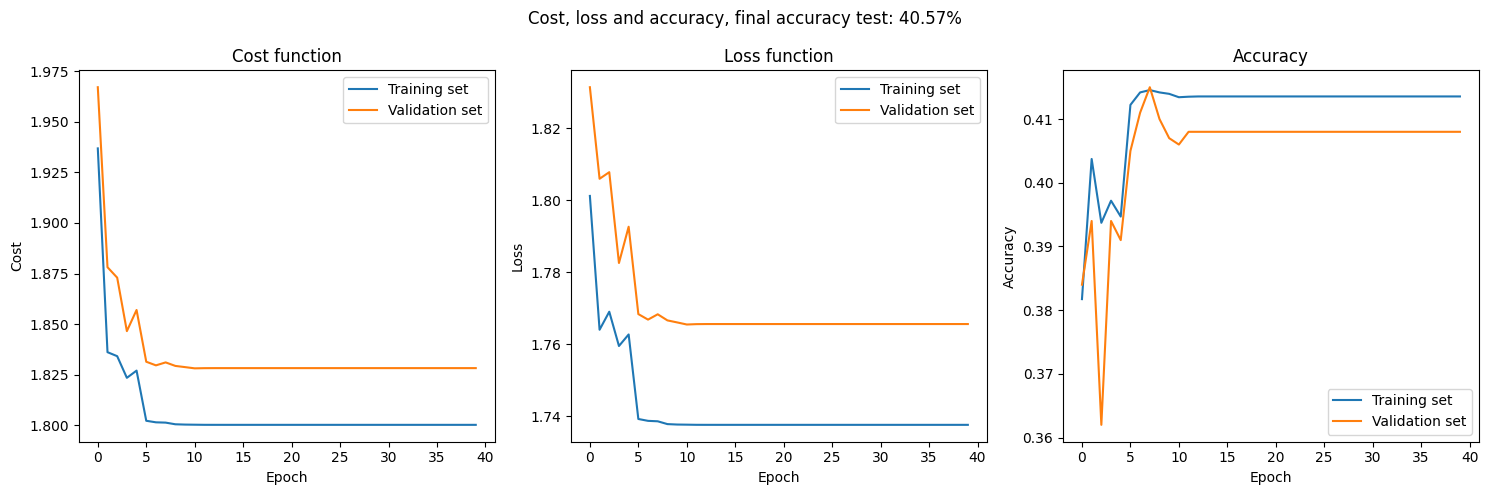

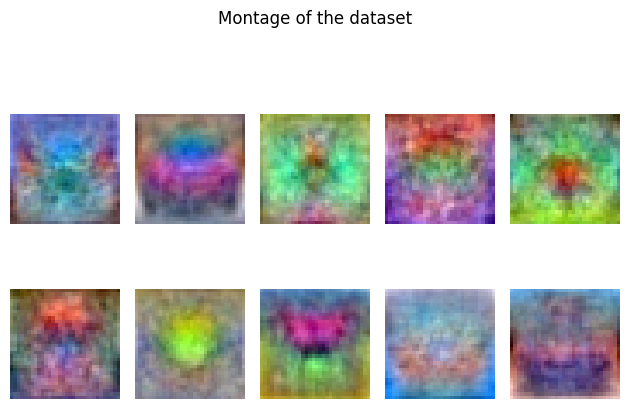

In [96]:
lmbda = 0.2
n_batch = 200
n_epochs = 40
eta = 0.01  # Starting with a higher learning rate because it will be decayed
train_and_plot_step_decay(X_train, Y_train, y_train, X_val, Y_val,
                          y_val, X_test, y_test, "_all_data_step_decay", save=True, verbose=False, lmbda=lmbda, n_batch=n_batch, n_epochs=n_epochs, eta=eta)

## Exercice 2.2 - Train network - multiple binary cross-entropy losses

### Utils


In [97]:
def sigmoid(x):
    """Standard definition of the sigmoid function """
    s = np.exp(x)
    return s / (1 + s)


def evaluate_classifier_sigmoid(X, W, b):
    """ Evaluate the network function with sigmoid """
    return sigmoid(W @ X + b)


def multi_binary_cross_entropy(Y, P):
    """ Compute the multi binary cross entropy """
    return -np.sum(Y * np.log(P) + (1 - Y) * np.log(1 - P), axis=1) / Y.shape[0]


def compute_gradients_multi_binary_cross_entropy(X, Y, P):
    """ Compute the gradients of the multi binary cross entropy """
    return (P - Y) @ X.T / Y.shape[0], np.sum(P-Y, axis=1, keepdims=True) / Y.shape[0]

In [98]:
def mini_batch_gd_sigmoid(X_train, Y_train, y_train, X_val, Y_val, y_val, W, b, n_batch=200, n_epochs=50, eta=.001, verbose=True):
    """ Implement the mini-batch gradient descent algorithm """
    n = X_train.shape[1]
    costs_train, costs_val = [], []
    accuracies_train, accuracies_val = [], []
    for epoch in range(n_epochs):
        # Shuffle the data
        indices = np.random.permutation(n)
        X_train_shuffled = X_train[:, indices]
        Y_train_shuffled = Y_train[:, indices]
        for j in range(0, n, n_batch):
            j_end = min(j + n_batch, n)
            X_batch = X_train_shuffled[:, j:j_end]
            Y_batch = Y_train_shuffled[:, j:j_end]
            P_batch = evaluate_classifier_sigmoid(X_batch, W, b)
            grad_W, grad_b = compute_gradients_multi_binary_cross_entropy(
                X_batch, Y_batch, P_batch)
            W -= eta * grad_W
            b -= eta * grad_b
        losses_train.append(multi_binary_cross_entropy(Y_train, evaluate_classifier_sigmoid(
            X_train, W, b)))
        losses_val.append(multi_binary_cross_entropy(Y_val, evaluate_classifier_sigmoid(
            X_val, W, b)))
        accuracies_train.append(compute_accuracy(X_train, y_train, W, b))
        accuracies_val.append(compute_accuracy(X_val, y_val, W, b))
        if verbose:
            print(f"Epoch {epoch + 1}/{n_epochs}: Cost train: {costs_train[-1]:.4f}, Cost val: {
                costs_val[-1]:.4f}, Accuracy train: {accuracies_train[-1]:.4f}, Accuracy val: {accuracies_val[-1]:.4f}")
    return W, b, losses_train, losses_val, accuracies_train, accuracies_val

In [99]:
W, b = initialize_parameters(Y_train.shape[0], X_train.shape[0])
W, b, losses_train, losses_val, accuracies_train, accuracies_val = mini_batch_gd_sigmoid(
    X_train, Y_train, y_train, X_val, Y_val, y_val, W, b, n_batch=200, n_epochs=50, eta=.001, verbose=False)

In [102]:
# Make a histogram plot of the probability for the ground truth class for the examples correctly and those incorrectly classified
P_train = evaluate_classifier_sigmoid(X_train, W, b)
P_val = evaluate_classifier_sigmoid(X_val, W, b)
P_test = evaluate_classifier_sigmoid(X_test, W, b)
y_train_pred = np.argmax(P_train, axis=0)
y_val_pred = np.argmax(P_val, axis=0)
y_test_pred = np.argmax(P_test, axis=0)
correct_train = y_train_pred == y_train
correct_val = y_val_pred == y_val
correct_test = y_test_pred == y_test
prob_train = P_train[y_train, np.arange(P_train.shape[1])]
prob_val = P_val[y_val, np.arange(P_val.shape[1])]
prob_test = P_test[y_test, np.arange(P_test.shape[1])]
plt.figure()
plt.hist(prob_train[correct_train], bins=20, alpha=0.5, label='Correct')
plt.hist(prob_train[~correct_train], bins=20, alpha=0.5, label='Incorrect')
plt.legend()
plt.title(f"Histogram of the probability on the training set, accuracy: {
          accuracies_train[-1]*100:.2f}%")
plt.xlabel("Probability")
plt.ylabel("Number of examples")
plt.savefig('Result_Pics/histogram_train.png')
plt.clf()
plt.hist(prob_val[correct_val], bins=20, alpha=0.5, label='Correct')
plt.hist(prob_val[~correct_val], bins=20, alpha=0.5, label='Incorrect')
plt.legend()
plt.title(f"Histogram of the probability fon the validation set, accuracy: {
          accuracies_train[-1]*100:.2f}%")
plt.xlabel("Probability")
plt.ylabel("Number of examples")
plt.savefig('Result_Pics/histogram_val.png')
plt.clf()
plt.hist(prob_test[correct_test], bins=20, alpha=0.5, label='Correct')
plt.hist(prob_test[~correct_test], bins=20, alpha=0.5, label='Incorrect')
plt.legend()
plt.title(f"Histogram of the probability on the test set, accuracy: {
          accuracies_train[-1]*100:.2f}%")
plt.xlabel("Probability")
plt.ylabel("Number of examples")
plt.savefig('Result_Pics/histogram_test.png')
plt.clf()
print("\nComputed the histograms")
plt.show()


Computed the histograms


<Figure size 640x480 with 0 Axes>